# Predicting Stock Prices Using Insider Data

## 1 Preprocessing Both Datasets

### 1.1 Import Data

In [15]:
import os
import pathlib
import pandas as pd

companies_base_dir = '/Users/saad/Documents/UIC/Semester 1/Machine Learning/project/class-project-odin-s-sight/data/companies/META'

insider_data = pd.read_csv(os.path.join(companies_base_dir, 'insider_data.csv'))
stock_data = pd.read_csv(os.path.join(companies_base_dir, 'stock_data.csv'))

### 1.2 Droping Columns

In [16]:
insider_data = insider_data.drop(columns=['company_name', 'ticker', 'insider_name', 'job_title', 'trade_type', 'final_shares_owned', 'change_in_shares_owned'])

### 1.3 Changing Column Data

In [17]:
# insider_data['trade_type'] = insider_data['trade_type'].replace({'S': 1, 'P': 0})
insider_data['filing_date'] = pd.to_datetime(insider_data['filing_date'])
stock_data['Date'] = pd.to_datetime(stock_data['Date'], utc=True).dt.tz_localize(None)

print(insider_data.shape)
print(stock_data.shape)

(10894, 4)
(3110, 6)


### 1.4 Merging Rows with Same Dates

In [18]:
insider_data = (
    insider_data.groupby("filing_date", as_index=False)
    .agg({
        "price": "mean",
        "quantity_traded": "sum",
        "value_of_shares_traded": "sum"
    })
)

insider_data.shape

(204, 4)

### 1.5 Adding Zero Vectors for Empty Rows

In [19]:
stock_data["Date"] = stock_data["Date"].dt.date
all_dates = stock_data["Date"]

# Step 3: Reindex insider data using stock data's dates
insider_data = (
    insider_data.set_index("filing_date")  # Set filing_date as index
    .reindex(all_dates)  # Align with stock dates
    .fillna(0)  # Fill missing rows with zeros
    .reset_index()  # Reset index to make 'filing_date' a column again
)

# Ensure consistent data types for numeric columns
numeric_columns = ["price", "quantity_traded", "value_of_shares_traded"]
insider_data[numeric_columns] = insider_data[numeric_columns].astype(float)

# Rename the index column back to 'filing_date'
insider_data.rename(columns={'Date': 'filing_date'}, inplace=True)

# Ensure the data types remain consistent (e.g., integer for zero-filled columns)
# Replace missing entries with explicit zeros where necessary
numeric_columns = ['price', 'quantity_traded', 'value_of_shares_traded']
insider_data[numeric_columns] = insider_data[numeric_columns].astype(float).fillna(0)

stock_data['Date'] = pd.to_datetime(stock_data['Date'], utc=True).dt.tz_localize(None)
insider_data['filing_date'] = pd.to_datetime(insider_data['filing_date'])


In [20]:
insider_data.shape

(3110, 4)

### 1.6 Viewing the Data

In [21]:
print(insider_data.shape)
insider_data

(3110, 4)


,filing_date,price,quantity_traded,value_of_shares_traded
0,2012-05-18,0.000,0.0,0.0
1,2012-05-21,0.000,0.0,0.0
2,2012-05-22,0.000,0.0,0.0
3,2012-05-23,0.000,0.0,0.0
4,2012-05-24,0.000,0.0,0.0
...,...,...,...,...
3105,2024-09-23,557.525,-20000.0,-11150500.0
3106,2024-09-24,560.000,-1652.0,-925120.0
3107,2024-09-25,569.930,-10000.0,-5699300.0
3108,2024-09-26,567.000,-905.0,-513135.0


In [22]:
print(stock_data.shape)
stock_data

(3110, 6)


,Date,Open,High,Low,Close,Volume
0,2012-05-18,41.923775,44.864921,37.885933,38.115242,573576400
1,2012-05-21,36.420340,36.549951,32.900938,33.927845,168192700
2,2012-05-22,32.512110,33.489168,30.847123,30.906942,101786600
3,2012-05-23,31.275832,32.402439,31.265862,31.903940,73600000
4,2012-05-24,32.851089,33.110307,31.674631,32.930847,50237200
...,...,...,...,...,...,...
3105,2024-09-23,569.500000,573.979980,562.409973,564.409973,12830700
3106,2024-09-24,566.679993,567.750000,554.190002,563.330017,12993000
3107,2024-09-25,564.049988,576.880005,563.719971,568.309998,16543400
3108,2024-09-26,575.729980,577.400024,562.349976,567.840027,14400800


## 2 Fitting the Model on Stock Data Only

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch import nn, optim
import torch

# Convert 'Open' prices to a numpy array
open_prices = stock_data['Open'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
open_prices_scaled = scaler.fit_transform(open_prices)

# Create sequences of 60 timesteps and corresponding labels
X, y = [], []
sequence_length = 60
for i in range(sequence_length, len(open_prices_scaled)):
    X.append(open_prices_scaled[i-sequence_length:i, 0])
    y.append(open_prices_scaled[i, 0])

X, y = np.array(X), np.array(y)

# Split the data into training and testing sets
split_ratio = 0.99
train_size = int(len(X) * split_ratio)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Reshape input data to 3D (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

print(y_train.shape)

# Define the LSTM model
class StockLSTM(nn.Module):
    def __init__(self):
        super(StockLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=4, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(50, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Get the last timestep output
        return out

# Instantiate the model, define loss and optimizer
model = StockLSTM()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

torch.Size([3019])


Epoch [10/100], Train Loss: 0.0407, Test Loss: 0.3303
Epoch [20/100], Train Loss: 0.0397, Test Loss: 0.4301
Epoch [30/100], Train Loss: 0.0392, Test Loss: 0.4095
Epoch [40/100], Train Loss: 0.0342, Test Loss: 0.2591
Epoch [50/100], Train Loss: 0.0088, Test Loss: 0.0413
Epoch [60/100], Train Loss: 0.0052, Test Loss: 0.0715
Epoch [70/100], Train Loss: 0.0029, Test Loss: 0.0173
Epoch [80/100], Train Loss: 0.0019, Test Loss: 0.0145
Epoch [90/100], Train Loss: 0.0014, Test Loss: 0.0047
Epoch [100/100], Train Loss: 0.0011, Test Loss: 0.0077


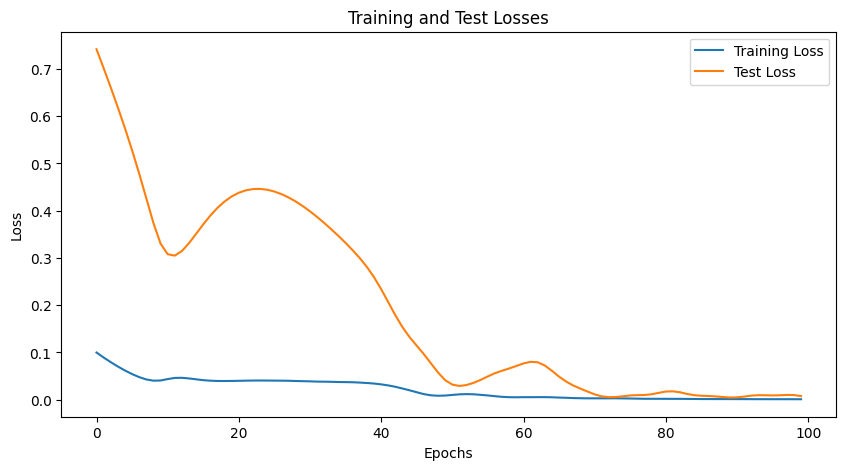

In [24]:
# Training loop
epochs = 100
batch_size = 32
train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    train_loss = criterion(output.squeeze(), y_train)
    train_loss.backward()
    optimizer.step()
    train_losses.append(train_loss.item())

    # Evaluate on test data
    model.eval()
    with torch.no_grad():
        test_output = model(X_test)
        test_loss = criterion(test_output.squeeze(), y_test)
        test_losses.append(test_loss.item())

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

# Plot training and test losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Training and Test Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Mean Squared Error (MSE): 2385.9851
Mean Absolute Error (MAE): 44.5937
Mean Absolute Percentage Error (MAPE): 8.26%


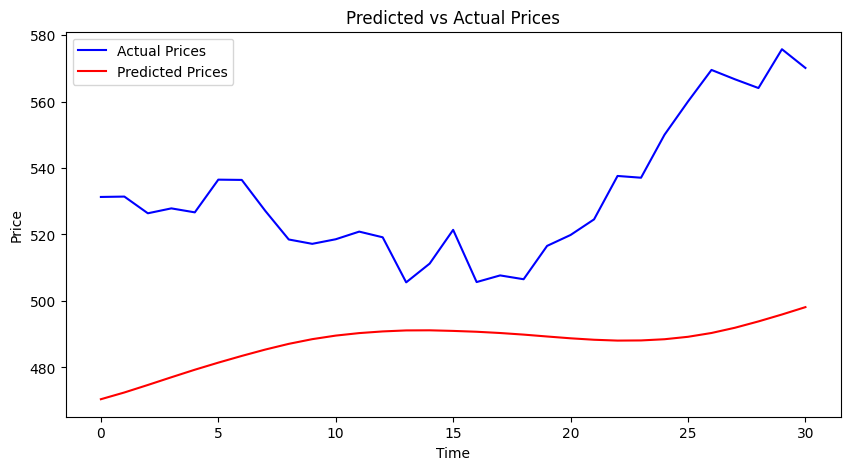

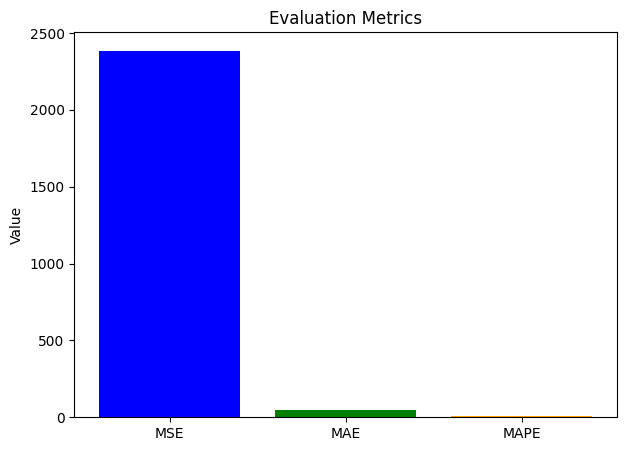

In [25]:
# Evaluate on test data
model.eval()
with torch.no_grad():
    predictions = model(X_test).squeeze()
    predictions = scaler.inverse_transform(predictions.numpy().reshape(-1, 1)).flatten()
    actuals = scaler.inverse_transform(y_test.numpy().reshape(-1, 1)).flatten()

# Calculate metrics
mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)
mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Plot predictions vs actuals
plt.figure(figsize=(10, 5))
plt.plot(actuals, label="Actual Prices", color="blue")
plt.plot(predictions, label="Predicted Prices", color="red")
plt.title("Predicted vs Actual Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

# Plot error metrics
metrics = {"MSE": mse, "MAE": mae, "MAPE": mape}
plt.figure(figsize=(7, 5))
plt.bar(metrics.keys(), metrics.values(), color=["blue", "green", "orange"])
plt.title("Evaluation Metrics")
plt.ylabel("Value")
plt.show()

## 3 Fitting the Model on Both Datasets

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch import nn, optim
import torch

# Align insider data with stock data by merging on date
stock_data["Date"] = stock_data["Date"].dt.date
insider_data["filing_date"] = insider_data["filing_date"].dt.date

merged_data = pd.merge(
    stock_data, insider_data, left_on="Date", right_on="filing_date", how="left"
).drop(columns=["filing_date"])

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(merged_data.drop(columns=["Date"]))

# Create sequences for stock and insider features separately
sequence_length = 60
X_stock, X_insider, y = [], [], []

for i in range(sequence_length, len(scaled_data)):
    X_stock.append(scaled_data[i-sequence_length:i, :5])  # First 5 columns: stock features
    X_insider.append(scaled_data[i-sequence_length:i, 5:])  # Next 3 columns: insider features
    y.append(scaled_data[i, 3])  # Target: 'Close'

X_stock, X_insider, y = np.array(X_stock), np.array(X_insider), np.array(y)

# Split data into training and testing sets
split_ratio = 0.99
train_size = int(len(X_stock) * split_ratio)
X_stock_train, X_stock_test = X_stock[:train_size], X_stock[train_size:]
X_insider_train, X_insider_test = X_insider[:train_size], X_insider[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert data to PyTorch tensors
X_stock_train = torch.tensor(X_stock_train, dtype=torch.float32)
X_stock_test = torch.tensor(X_stock_test, dtype=torch.float32)
X_insider_train = torch.tensor(X_insider_train, dtype=torch.float32)
X_insider_test = torch.tensor(X_insider_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Define the combined model
class CombinedLSTM(nn.Module):
    def __init__(self):
        super(CombinedLSTM, self).__init__()
        self.lstm_stock = nn.LSTM(input_size=5, hidden_size=50, num_layers=2, batch_first=True, dropout=0.2)
        self.lstm_insider = nn.LSTM(input_size=3, hidden_size=50, num_layers=2, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(100, 1)

    def forward(self, stock_input, insider_input):
        _, (stock_hidden, _) = self.lstm_stock(stock_input)
        _, (insider_hidden, _) = self.lstm_insider(insider_input)
        combined = torch.cat((stock_hidden[-1], insider_hidden[-1]), dim=1)
        output = self.fc(combined)
        return output

# Instantiate the model, define loss and optimizer
model = CombinedLSTM()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch [10/100], Train Loss: 0.0396, Test Loss: 0.2455
Epoch [20/100], Train Loss: 0.0236, Test Loss: 0.2071
Epoch [30/100], Train Loss: 0.0039, Test Loss: 0.0025
Epoch [40/100], Train Loss: 0.0027, Test Loss: 0.0034
Epoch [50/100], Train Loss: 0.0011, Test Loss: 0.0109
Epoch [60/100], Train Loss: 0.0008, Test Loss: 0.0101
Epoch [70/100], Train Loss: 0.0008, Test Loss: 0.0075
Epoch [80/100], Train Loss: 0.0006, Test Loss: 0.0085
Epoch [90/100], Train Loss: 0.0006, Test Loss: 0.0048
Epoch [100/100], Train Loss: 0.0005, Test Loss: 0.0041


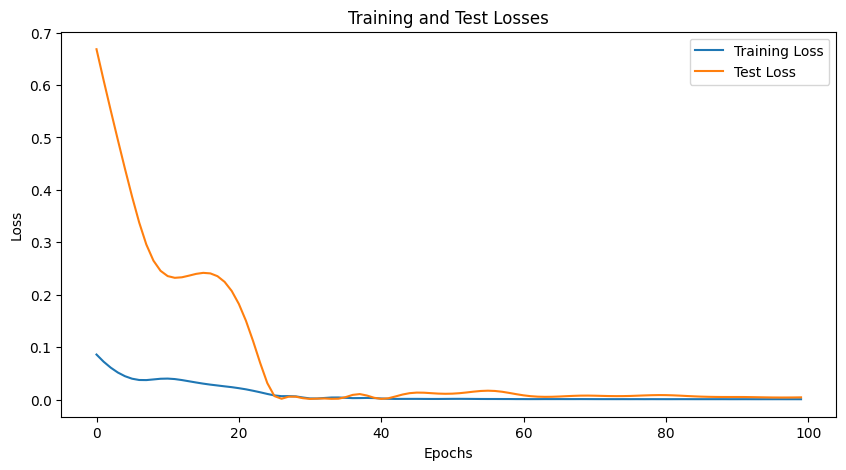

In [27]:
# Training loop
epochs = 100
train_losses, test_losses = [], []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_stock_train, X_insider_train).squeeze()
    train_loss = criterion(output, y_train)
    train_loss.backward()
    optimizer.step()
    train_losses.append(train_loss.item())

    # Evaluate on test data
    model.eval()
    with torch.no_grad():
        test_output = model(X_stock_test, X_insider_test).squeeze()
        test_loss = criterion(test_output, y_test)
        test_losses.append(test_loss.item())

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

# Plot training and test losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Training and Test Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Mean Squared Error (MSE): 1248.9220
Mean Absolute Error (MAE): 30.4604
Mean Absolute Percentage Error (MAPE): 5.62%


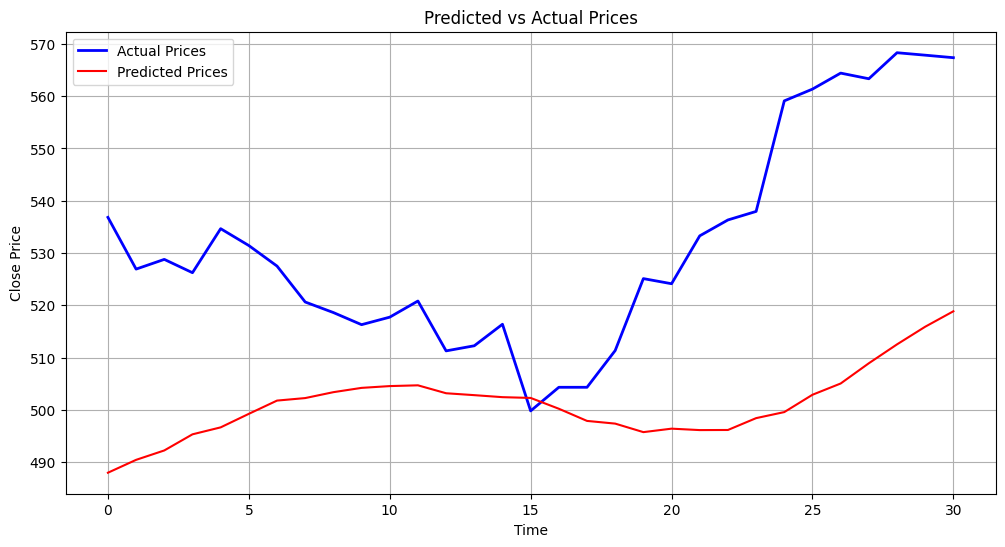

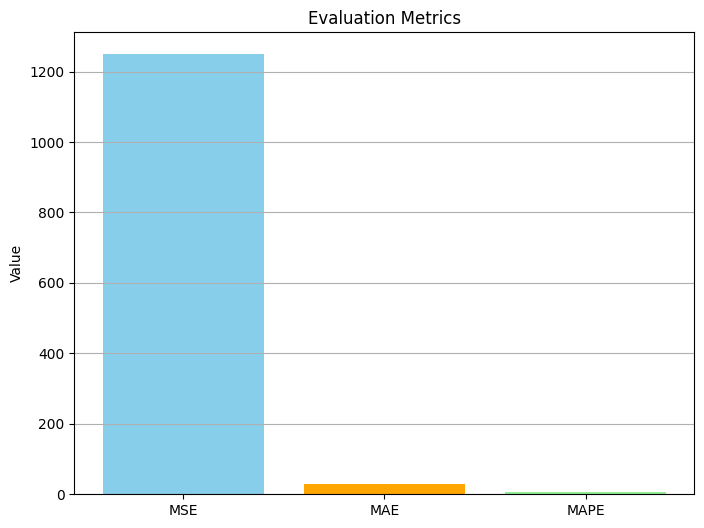

In [28]:
# Evaluate the CombinedLSTM model on test data
model.eval()
with torch.no_grad():
    # Generate predictions using the combined model
    predictions = model(X_stock_test, X_insider_test).squeeze().numpy()

    # Prepare a placeholder for all columns with zeros, only filling the 'Close' column
    placeholder_predictions = np.zeros((predictions.shape[0], scaled_data.shape[1]))
    placeholder_predictions[:, 3] = predictions  # 'Close' is the 4th column (index 3)

    placeholder_actuals = np.zeros((y_test.numpy().shape[0], scaled_data.shape[1]))
    placeholder_actuals[:, 3] = y_test.numpy()  # Actual 'Close' values

    # Inverse transform
    predictions = scaler.inverse_transform(placeholder_predictions)[:, 3]
    actuals = scaler.inverse_transform(placeholder_actuals)[:, 3]

# Calculate evaluation metrics
mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)
mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Plot predictions vs actuals
plt.figure(figsize=(12, 6))
plt.plot(actuals, label="Actual Prices", color="blue", linewidth=2)
plt.plot(predictions, label="Predicted Prices", color="red", linestyle="-")
plt.title("Predicted vs Actual Prices")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.grid()
plt.show()

# Plot error metrics
metrics = {"MSE": mse, "MAE": mae, "MAPE": mape}
plt.figure(figsize=(8, 6))
plt.bar(metrics.keys(), metrics.values(), color=["skyblue", "orange", "lightgreen"])
plt.title("Evaluation Metrics")
plt.ylabel("Value")
plt.grid(axis="y")
plt.show()
